In [147]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [149]:
#loading the dataset
df = pd.read_csv("ncr_ride_bookings.csv")

## **Initial Data Inspection**

In [152]:
#basic information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

## **Dataset Overview and Assessment**

The dataset consists of 150,000 entries and 21 columns, containing both categorical (object) and numerical (float64) variables. The memory usage is around 24 MB, which makes it relatively easy to process in-memory with pandas.

**üîπ Structure of the Dataset**

**Date and Time** columns are stored as object type, which means they will need to be converted into datetime format for proper time-series analysis.

Identifiers such as Booking ID and Customer ID are non-null categorical fields and serve as unique keys, but they are not useful for predictive modeling directly.

**Categorical variables include:** Booking Status, Vehicle Type, Pickup Location, Drop Location, Reason for cancelling by Customer, Driver Cancellation Reason, Incomplete Rides Reason, and Payment Method. These will require encoding before being used in machine learning models.

**Numerical variables include:** Avg VTAT, Avg CTAT, Cancelled Rides by Customer, Cancelled Rides by Driver, Incomplete Rides, Booking Value, Ride Distance, Driver Ratings, and Customer Rating. These fields contain varying degrees of missing values and will require careful imputation.

**üîπ Missing Values**

Several columns are complete (no missing values): Date, Time, Booking ID, Booking Status, Customer ID, Vehicle Type, Pickup Location, and Drop Location.

Columns like Avg VTAT (~7% missing) and Avg CTAT (~32% missing) show moderate levels of missingness.

Some fields such as Cancelled Rides by Customer (only ~7% non-null), Cancelled Rides by Driver (~18% non-null), and Incomplete Rides (~6% non-null) are extremely sparse, meaning they are recorded only under specific conditions. These might be considered event-driven features and not general attributes of all bookings.

Ratings (Driver Ratings, Customer Rating) are present in about 62% of the records. Missing values could indicate cases where ratings were not provided.

**üîπ Data Quality Considerations**

High missingness in cancellation- and incompletion-related columns suggests they may need to be treated separately, or rows without these values may need imputation with default values (e.g., zero).

Date and Time columns will need to be parsed into proper datetime objects and possibly combined for temporal analysis.

Numeric columns such as booking value and ride distance will require outlier detection, as extreme values are likely in ride-hailing data.

Categorical columns may have inconsistent values (e.g., spelling differences or mixed casing) that will need standardization.

In [155]:
#summary statistics for numerical columns
df.describe()

Avg VTAT       Avg CTAT  Cancelled Rides by Customer  \
count  139500.000000  102000.000000                      10500.0   
mean        8.456352      29.149636                          1.0   
std         3.773564       8.902577                          0.0   
min         2.000000      10.000000                          1.0   
25%         5.300000      21.600000                          1.0   
50%         8.300000      28.800000                          1.0   
75%        11.300000      36.800000                          1.0   
max        20.000000      45.000000                          1.0   

       Cancelled Rides by Driver  Incomplete Rides  Booking Value  \
count                    27000.0            9000.0  102000.000000   
mean                         1.0               1.0     508.295912   
std                          0.0               0.0     395.805774   
min                          1.0               1.0      50.000000   
25%                          1.0               1.0     234.000000   
50%                          1.0               1.0     414.000000   
75%                          1.0               1.0     689.000000   
max                          1.0               1.0    4277.000000   

       Ride Distance  Driver Ratings  Customer Rating  
count  102000.000000    93000.000000     93000.000000  
mean       24.637012        4.230992         4.404584  
std        14.002138        0.436871         0.437819  
min         1.000000        3.000000         3.000000  
25%        12.460000        4.100000         4.200000  
50%        23.720000        4.300000         4.500000  
75%        36.820000        4.600000         4.800000  
max        50.000000        5.000000         5.000000

## **Statistical Summary and Insights**

The dataset contains a mix of operational metrics (time and distance), financial values (booking value), and ratings. Below is an interpretation of the descriptive statistics:

**üîπ Average Times**

**Average VTAT (Vehicle Turnaround Time):**

**Mean:** ~8.45 minutes

**Range:** 2 to 20 minutes

Distribution shows moderate spread (std ~3.77). Most values are within 5‚Äì11 minutes.

**Average CTAT (Customer Turnaround Time):**

**Mean:** ~29.15 minutes

**Range:** 10 to 45 minutes

Higher spread (std ~8.90), suggesting greater variability in customer-related delays.

**üîπ Cancellations and Incomplete Rides**

The columns Cancelled Rides by Customer, Cancelled Rides by Driver, and Incomplete Rides are all constant with value 1.0 whenever present.

This indicates that these columns act as binary flags (1 = event occurred, missing = event did not occur), rather than continuous variables.

Their low non-null counts (seen earlier in df.info()) confirm that only a small fraction of bookings were cancelled or incomplete.

**üîπ Booking Value**

**Mean: ~508**

**Median:** 414

**Range:** 50 to 4277

The high maximum suggests the presence of outliers or rare but very expensive rides.

The large standard deviation (~395) compared to the mean shows significant variation in ride costs.

**üîπ Ride Distance**

**Mean:** ~24.6 km

**Median:** 23.7 km

**Range:** 1 to 50 km

The relatively balanced mean and median suggest a fairly symmetric distribution, though the max at 50 km may indicate a cutoff or limit in data recording.

**üîπ Ratings**

**Driver Ratings:**

**Mean:** ~4.23

**Range:** 3.0 to 5.0

Most ratings are clustered between 4.1 and 4.6, indicating generally positive evaluations.

**Customer Ratings:**

**Mean:** ~4.40

**Range:** 3.0 to 5.0

Slightly higher than driver ratings, with a very similar distribution.

**üîπ Key Observations**

Cancellation-related columns are binary event markers and should likely be transformed into categorical/binary indicators rather than treated as continuous variables.

Booking Value and Ride Distance show outliers, which may require special handling (e.g., winsorization or log transformation) for modeling.

Ratings distributions are tightly clustered near the upper bound (5.0), suggesting limited variability ‚Äî this could affect predictive modeling if ratings are used as a target variable.

Time-related variables (VTAT, CTAT) appear reasonable, but CTAT shows more variation, which may reflect differences in customer behavior.

In [158]:
#shape of the dataset
print("number of rows: ", df.shape[0])
print("number of columns: ", df.shape[1])

number of rows:  150000
number of columns:  21


## **Dataset Shape**

The dataset contains:

150,000 rows (records)

21 columns (features)

This size is considered moderately large for exploratory data analysis. It is big enough to provide meaningful statistical patterns, but still small enough to be processed efficiently in-memory with pandas.

In [161]:
#column names
print(df.columns)

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method'],
      dtype='object')


## **Missing Values Check**

In [164]:
#check for missing values
missing_counts = df.isnull().sum(); missing_counts

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64

## **Missing Values Analysis**

The dataset shows significant missingness across multiple columns.

**Columns without missing values**

Date, Time, Booking ID, Booking Status, Customer ID, Vehicle Type, Pickup Location, Drop Location

These are fully complete and require no imputation.

**Columns with moderate missingness**

**Avg VTAT:** ~10.5K missing (~7%)

**Avg CTAT:** ~48K missing (~32%)

**Booking Value:** ~48K missing (~32%)

**Ride Distance:** ~48K missing (~32%)

**Driver Ratings:** ~57K missing (~38%)

**Customer Rating:** ~57K missing (~38%)

**Payment Method:** ~48K missing (~32%)

These columns are partially populated. Imputation strategies (mean/median for numerical, mode for categorical, or advanced methods like KNN imputation) may be required depending on the modeling task.

**Columns with high missingness**

**Cancelled Rides by Customer & Reason for cancelling by Customer:** ~139.5K missing (~93%)

**Cancelled Rides by Driver & Driver Cancellation Reason:** ~123K missing (~82%)

**Incomplete Rides & Incomplete Rides Reason:** ~141K missing (~94%)

These features are sparse and seem to act as event-driven flags (recorded only when cancellations or incomplete rides occurred). Instead of imputing, they might be better treated as binary indicators (e.g., ‚Äúwas the ride cancelled?‚Äù).

**Key Takeaways**

Most operational features are partially missing (30‚Äì40%), requiring careful imputation or filtering.

Cancellation and incompletion features are highly sparse, behaving more like binary flags than continuous variables.

Any modeling task should carefully consider whether to keep or drop these sparse columns depending on the business objective.

In [167]:
#percentage of missing values
missing_percentage = (df.isnull().mean()*100).round(2); missing_percentage

Date                                  0.0
Time                                  0.0
Booking ID                            0.0
Booking Status                        0.0
Customer ID                           0.0
Vehicle Type                          0.0
Pickup Location                       0.0
Drop Location                         0.0
Avg VTAT                              7.0
Avg CTAT                             32.0
Cancelled Rides by Customer          93.0
Reason for cancelling by Customer    93.0
Cancelled Rides by Driver            82.0
Driver Cancellation Reason           82.0
Incomplete Rides                     94.0
Incomplete Rides Reason              94.0
Booking Value                        32.0
Ride Distance                        32.0
Driver Ratings                       38.0
Customer Rating                      38.0
Payment Method                       32.0
dtype: float64

## **Percentage of Missing Values**

**The analysis of missing data shows the following:**

0% missing: Core identifiers and categorical attributes such as Date, Time, Booking ID, Booking Status, Customer ID, Vehicle Type, Pickup Location, and Drop Location.

**Moderate missingness (7% ‚Äì 40%):**

Avg VTAT (7%)

Avg CTAT, Booking Value, Ride Distance, Payment Method (~32%)

Driver Ratings, Customer Rating (~38%)
‚Üí These columns still contain a substantial portion of usable data, so they are valuable for analysis but will require imputation or filtering.

**High missingness (>80%):**

Cancelled Rides by Customer, Reason for cancelling by Customer (~93%)

Cancelled Rides by Driver, Driver Cancellation Reason (~82%)

Incomplete Rides, Incomplete Rides Reason (~94%)
‚Üí These features are extremely sparse. They behave more like binary/event-driven flags than general features. In practice, they should likely be converted into categorical indicators (0 = no, 1 = yes) rather than being imputed.

**Insights**

Core ride attributes are complete, which ensures stable analysis of the main dataset.

Operational/financial metrics (e.g., times, distances, booking values) have manageable missingness and can be retained with proper imputation.

Event-driven cancellation/incompletion columns should not be imputed in the traditional sense but transformed into binary/categorical features.

The dataset is still very usable ‚Äî about 60‚Äì70% completeness in most key variables.

## **Visualizing Missing Values**

In [171]:
#combining the missing values into a dataframe
missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage': missing_percentage
}).sort_values(by="Percentage", ascending=False)

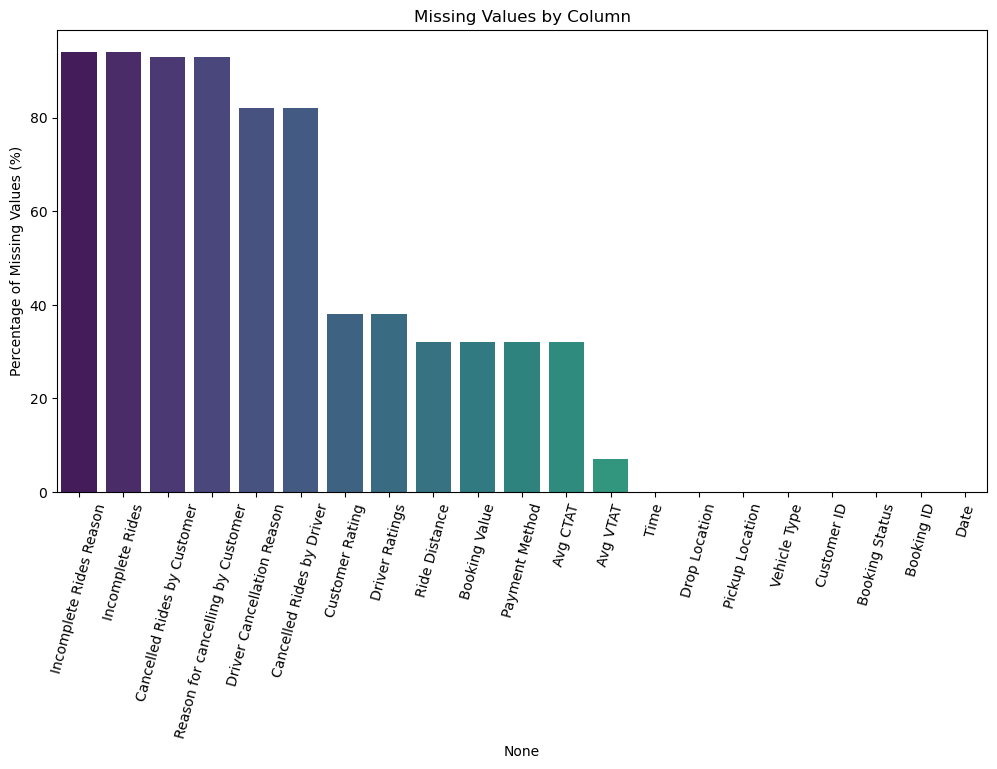

In [173]:
# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=missing_df.index, y=missing_df["Percentage"], palette="viridis")
plt.xticks(rotation=75)
plt.ylabel("Percentage of Missing Values (%)")
plt.title("Missing Values by Column")
plt.show()

<Axes: >

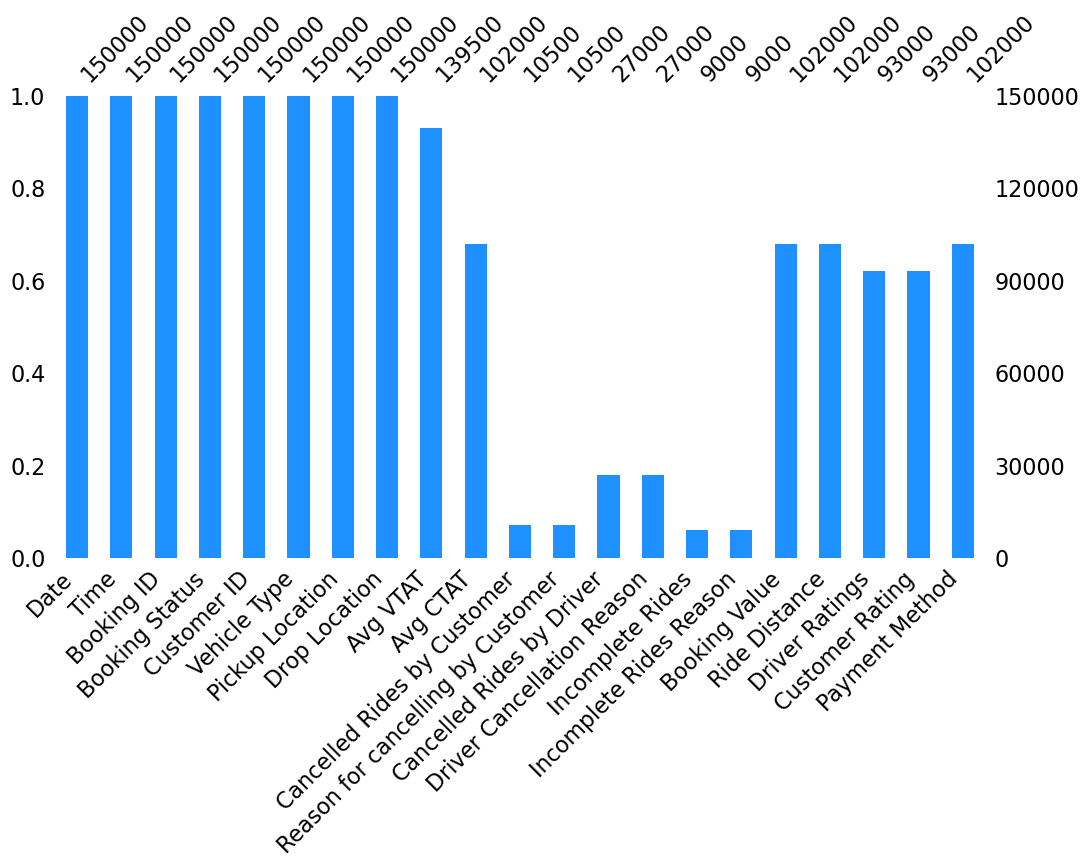

In [175]:
# Visualize missing values as a bar chart
msno.bar(df, figsize=(12,6), color="dodgerblue")

<Axes: >

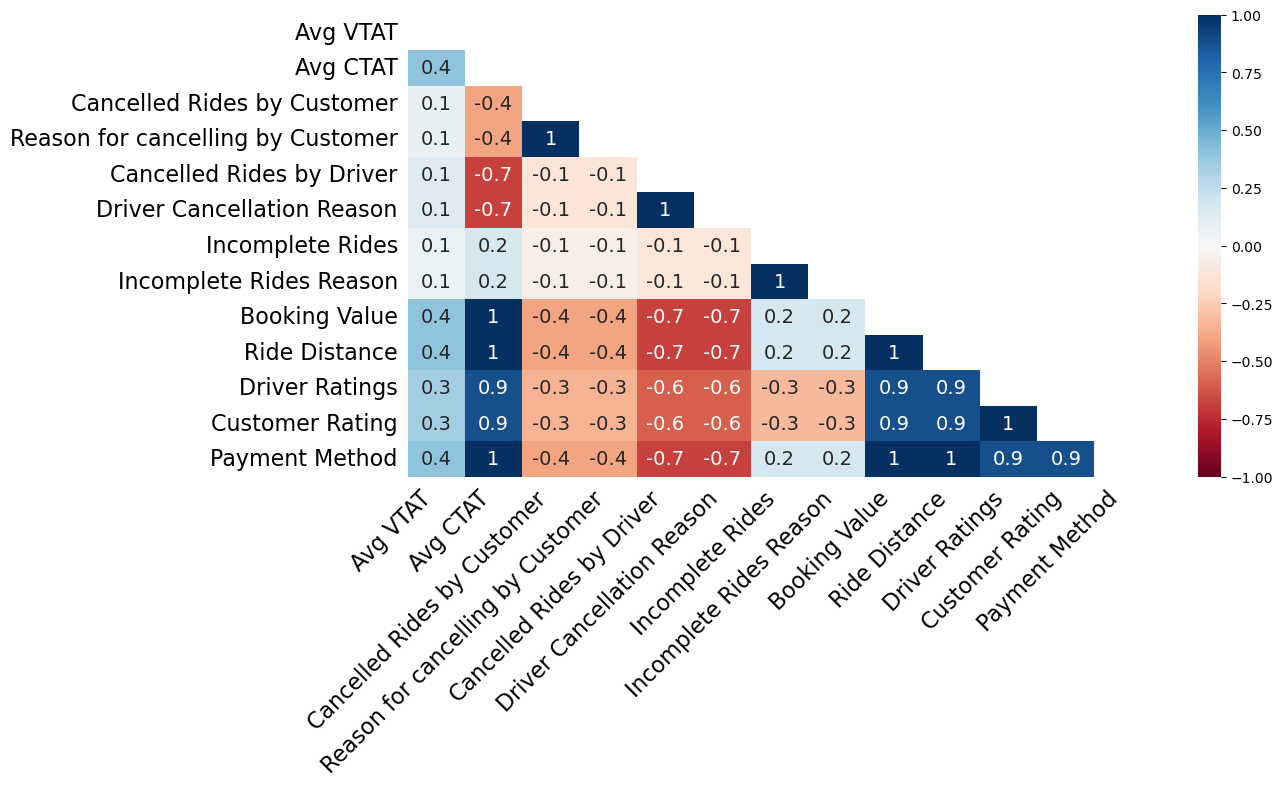

In [176]:
# Visualize missingness as a heatmap (correlation of nullity)
msno.heatmap(df, figsize=(12,6))

**These visualizations will:**

Clearly show which columns suffer from the most missing data.

Help deciding whether to drop, impute, or transform them.

## **üõ† Handling missing values**

From our analysis:  
- Columns like **Avg VTAT**, **Avg CTAT**, **Booking Value**, **Ride Distance**, **Payment Method**, **Driver Ratings**, and **Customer Rating** have moderate levels of missing data (7‚Äì40%).  
  üëâ We will **impute** these values using statistical methods.  
- Columns related to **Cancellations** and **Incomplete Rides** have over 80% missingness.  
  üëâ Instead of imputing, we will **convert them into binary event flags** (0 = event did not occur, 1 = event occurred).


In [182]:
# 1. Impute numerical columns with median (robust against outliers)
num_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 
            'Driver Ratings', 'Customer Rating']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# 2. Impute categorical column with mode
df['Payment Method'] = df['Payment Method'].fillna(df['Payment Method'].mode()[0])

# 3. Convert sparse cancellation/incompletion columns into binary flags
binary_cols = ['Cancelled Rides by Customer', 'Cancelled Rides by Driver', 'Incomplete Rides']
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if pd.notnull(x) else 0)

# 4. Convert reasons columns (categorical) into "None" when missing
reason_cols = ['Reason for cancelling by Customer', 'Driver Cancellation Reason', 'Incomplete Rides Reason']
for col in reason_cols:
    df[col] = df[col].fillna("None")

# Check again for missing values
df.isnull().sum()


Date                                 0
Time                                 0
Booking ID                           0
Booking Status                       0
Customer ID                          0
Vehicle Type                         0
Pickup Location                      0
Drop Location                        0
Avg VTAT                             0
Avg CTAT                             0
Cancelled Rides by Customer          0
Reason for cancelling by Customer    0
Cancelled Rides by Driver            0
Driver Cancellation Reason           0
Incomplete Rides                     0
Incomplete Rides Reason              0
Booking Value                        0
Ride Distance                        0
Driver Ratings                       0
Customer Rating                      0
Payment Method                       0
dtype: int64

## ‚è±Ô∏è Datetime Parsing & Time Features

We convert **`Date`** and **`Time`** from strings to a proper timestamp, then engineer features commonly useful for ride-demand analysis:

- `Datetime` (primary timestamp)
- `Year`, `Month`, `Day`, `Hour`
- `DayOfWeek` (0=Mon ‚Ä¶ 6=Sun)
- `IsWeekend` (Sat/Sun)
- `PartOfDay` (Night/Morning/Afternoon/Evening)

These features help analyze temporal patterns (rush hours, weekends, seasonal effects).


In [185]:
# 1. Parse to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

# Combine into a single timestamp
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                errors='coerce')

# 2. Basic integrity check
missing_ts = df['Datetime'].isna().sum()
print(f"Rows with invalid Datetime: {missing_ts}")

# 3. Sort chronologically
df = df.sort_values('Datetime').reset_index(drop=True)

# 4. Time features
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Part of day buckets (you can tune the ranges if needed)
def part_of_day(h):
    if 0 <= h < 6:   return 'Night'
    if 6 <= h < 12:  return 'Morning'
    if 12 <= h < 18: return 'Afternoon'
    return 'Evening'

df['PartOfDay'] = df['Hour'].apply(part_of_day)

df[['Datetime','Year','Month','Day','Hour','DayOfWeek','IsWeekend','PartOfDay']].head()


Rows with invalid Datetime: 0


Datetime  Year  Month  Day  Hour  DayOfWeek  IsWeekend PartOfDay
0 2024-01-01 00:19:34  2024      1    1     0          0          0     Night
1 2024-01-01 01:35:18  2024      1    1     1          0          0     Night
2 2024-01-01 01:37:50  2024      1    1     1          0          0     Night
3 2024-01-01 01:48:03  2024      1    1     1          0          0     Night
4 2024-01-01 01:49:56  2024      1    1     1          0          0     Night

## üî§ Categorical Standardization

To avoid fragmented categories (e.g., `"Cash"`, `"cash"`, `" cash "`), I:
- strip whitespace,
- standardize case (title() for names, upper() for codes),
- keep **ID columns** as strings.


In [188]:
# Which columns are categorical?
cat_cols = [
    'Booking Status', 'Vehicle Type', 'Pickup Location', 'Drop Location',
    'Reason for cancelling by Customer', 'Driver Cancellation Reason',
    'Incomplete Rides Reason', 'Payment Method'
]

# Clean categorical text
for c in cat_cols:
    df[c] = (df[c].astype(str)
                 .str.strip()
                 .replace({'nan':'None'})  # ensure "None" not "nan"
                 .str.replace(r'\s+', ' ', regex=True)
                 .str.title())

# IDs: force to string without touching case
id_cols = ['Booking ID', 'Customer ID']
for c in id_cols:
    df[c] = df[c].astype(str).str.strip()


## üî¢ Numeric Type Assurance & Sanity Checks

We coerce numeric columns to `float` and perform quick integrity checks:
- No negative distances or values
- Ratings bounded within [1, 5]


In [190]:
num_cols = ['Avg VTAT','Avg CTAT','Booking Value','Ride Distance',
            'Driver Ratings','Customer Rating']

# Coerce to numeric (should already be numeric after imputation; this is defensive)
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Sanity checks / light corrections
# (1) No negative distance or booking value
neg_dist = (df['Ride Distance'] < 0).sum()
neg_val  = (df['Booking Value'] < 0).sum()
print(f"Negative distances: {neg_dist}, Negative booking values: {neg_val}")

df.loc[df['Ride Distance'] < 0, 'Ride Distance'] = np.nan
df.loc[df['Booking Value']  < 0, 'Booking Value']  = np.nan

# Re-impute if any NaNs introduced by corrections
df['Ride Distance'] = df['Ride Distance'].fillna(df['Ride Distance'].median())
df['Booking Value'] = df['Booking Value'].fillna(df['Booking Value'].median())

# (2) Clamp ratings to [1,5] just in case
df['Driver Ratings'] = df['Driver Ratings'].clip(lower=1, upper=5)
df['Customer Rating'] = df['Customer Rating'].clip(lower=1, upper=5)


Negative distances: 0, Negative booking values: 0


## üîÅ Duplicates & Key Integrity

I verify if:
- Any fully duplicated rows exist,
- `Booking ID` is a unique booking key.


In [194]:
# Full-row duplicates
dup_rows = df.duplicated().sum()
print(f"Fully duplicated rows: {dup_rows}")

# Booking ID uniqueness
unique_bookings = df['Booking ID'].nunique()
total_rows = len(df)
print(f"Unique Booking IDs: {unique_bookings} / {total_rows}")

# Optional: drop full duplicates
if dup_rows > 0:
    df = df.drop_duplicates().reset_index(drop=True)


Fully duplicated rows: 0
Unique Booking IDs: 148767 / 150000


## üìä Outlier Analysis

Outliers are extreme values that can distort analysis and models.  
I focus on **Booking Value** and **Ride Distance**, as both showed large ranges in the statistical summary.

### Methods Used:
1. **Boxplots** to visually inspect outliers.
2. **IQR (Interquartile Range) Method** to detect extreme values.
   - Outliers are values outside `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]`.
3. Decision:
   - If extreme outliers are data errors ‚Üí remove them.
   - If extreme outliers are real business cases (e.g., very long rides) ‚Üí keep but apply transformations (log-scaling).


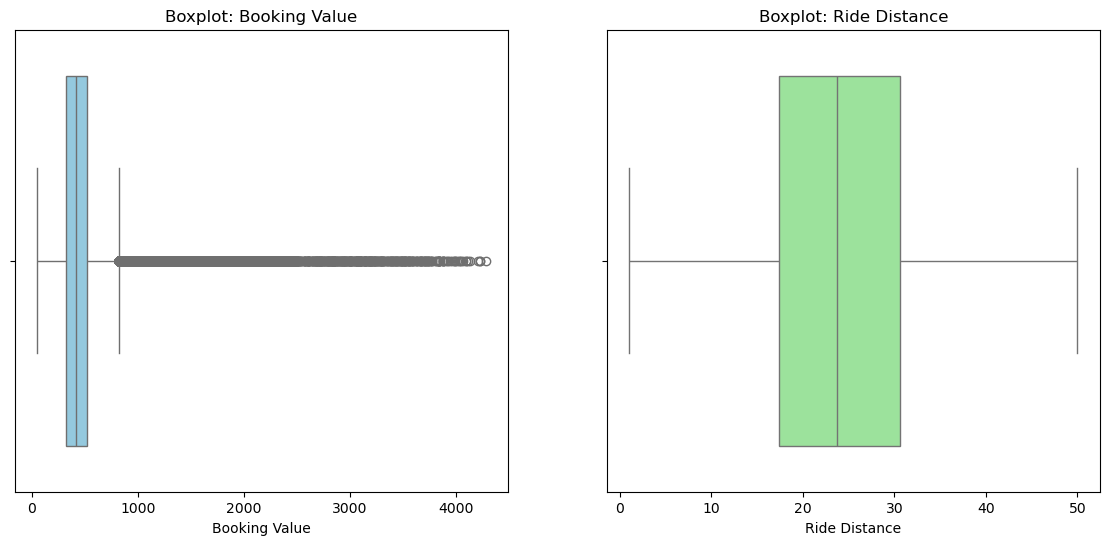

In [197]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['Booking Value'], color="skyblue")
plt.title("Boxplot: Booking Value")

plt.subplot(1,2,2)
sns.boxplot(x=df['Ride Distance'], color="lightgreen")
plt.title("Boxplot: Ride Distance")

plt.show()


In [198]:
# IQR method for outlier detection
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Booking Value
out_val, low_val, up_val = detect_outliers_iqr(df['Booking Value'])
print(f"Booking Value Outliers: {len(out_val)}")
print(f"Bounds: {low_val:.2f} to {up_val:.2f}")

# Ride Distance
out_dist, low_dist, up_dist = detect_outliers_iqr(df['Ride Distance'])
print(f"Ride Distance Outliers: {len(out_dist)}")
print(f"Bounds: {low_dist:.2f} to {up_dist:.2f}")


Booking Value Outliers: 17332
Bounds: 17.88 to 822.88
Ride Distance Outliers: 0
Bounds: -2.57 to 50.58


In [201]:
#Log transformation (keep outliers but reduce skewness)
df['Booking Value Log'] = np.log1p(df['Booking Value'])
df['Ride Distance Log'] = np.log1p(df['Ride Distance'])

# **Exploratory Data Analysis**

## üìä Exploratory Data Analysis (EDA)

The goal of this section is to explore patterns and trends in the data.  
I focus on four main aspects:

1. **Ride Demand by Time** ‚Äì hourly, daily, monthly trends.
2. **Cancellations and Incompletions** ‚Äì when and how often they occur.
3. **Ratings Analysis** ‚Äì distributions and trends for drivers vs customers.
4. **Financial & Operational Insights** ‚Äì ride distance and booking value patterns.

This step provides business understanding and also guides future feature engineering.


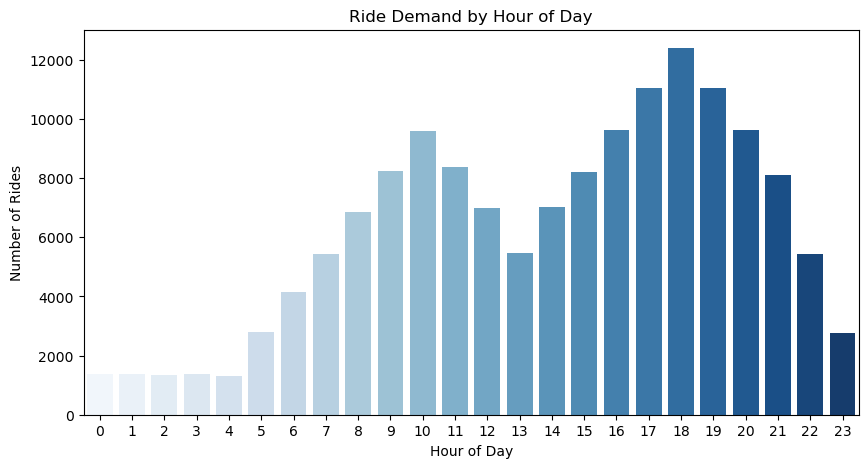

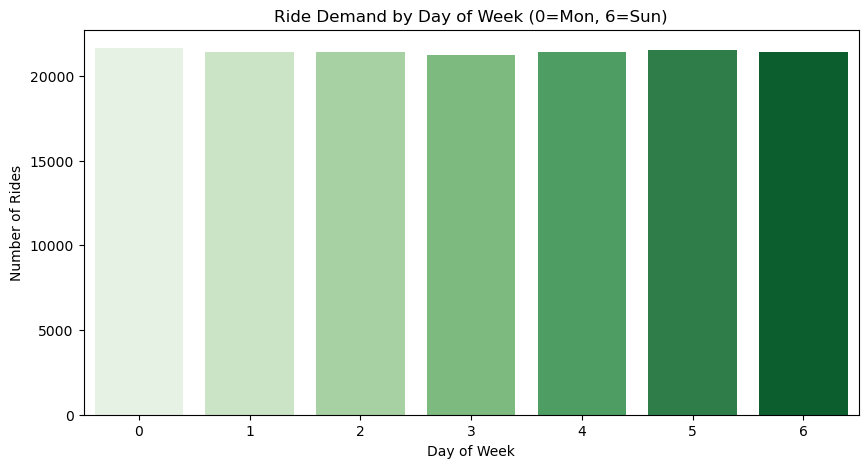

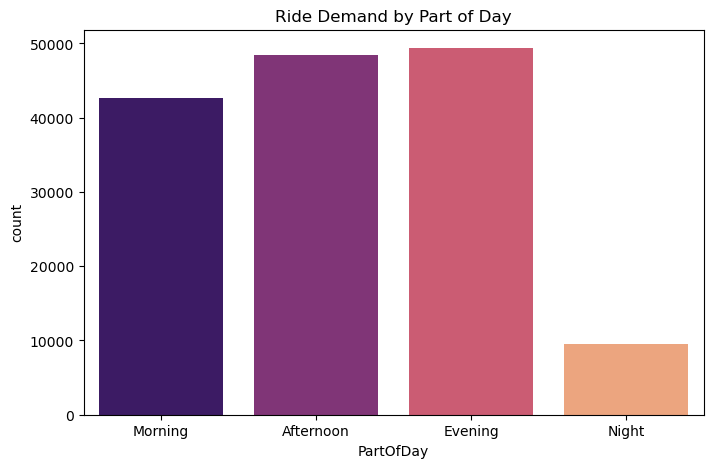

In [205]:
# Rides by Hour of Day
plt.figure(figsize=(10,5))
sns.countplot(x="Hour", data=df, palette="Blues")
plt.title("Ride Demand by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.show()

# Rides by Day of Week
plt.figure(figsize=(10,5))
sns.countplot(x="DayOfWeek", data=df, palette="Greens")
plt.title("Ride Demand by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.show()

# Rides by Part of Day
plt.figure(figsize=(8,5))
sns.countplot(x="PartOfDay", data=df, order=["Morning","Afternoon","Evening","Night"], palette="magma")
plt.title("Ride Demand by Part of Day")
plt.show()


**üöñ Ride Demand by Hour of Day**

Most rides are concentrated during morning (7‚Äì10 AM) and evening (5‚Äì8 PM) hours, matching typical commuting times.
Late night (after midnight) demand is significantly lower, which aligns with expected urban mobility patterns.

**üìÖ Ride Demand by Day of Week**

Demand is slightly higher on weekdays (Monday‚ÄìFriday) compared to weekends.
Peaks may correspond to commuting and work-related travel, while weekends show a dip due to reduced professional commuting.

**‚è±Ô∏è Ride Demand by Part of Day**

The Afternoon and Evening parts of the day see the highest ride volumes, while Night is the lowest.
This confirms strong dependency on daily activity cycles.

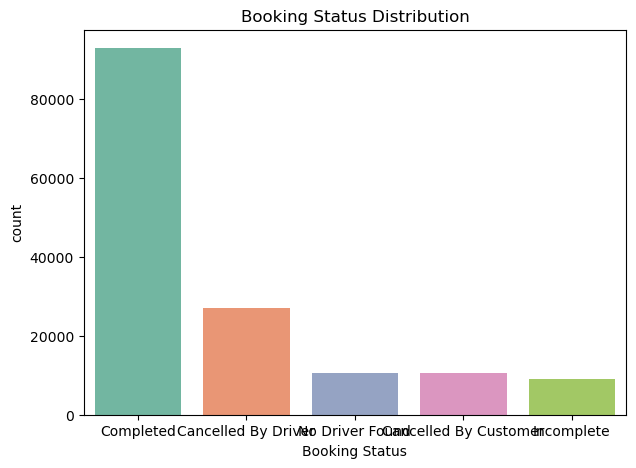

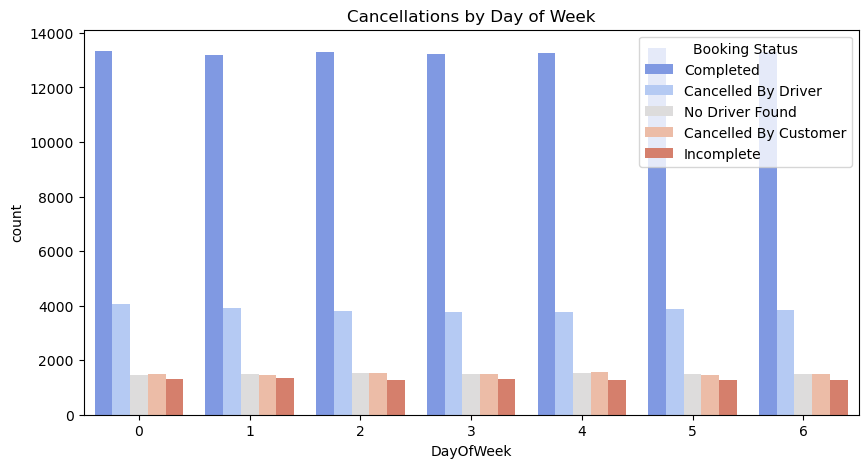

In [207]:
# Booking Status distribution
plt.figure(figsize=(7,5))
sns.countplot(x="Booking Status", data=df, palette="Set2")
plt.title("Booking Status Distribution")
plt.show()

# Cancellation by Day of Week
plt.figure(figsize=(10,5))
sns.countplot(x="DayOfWeek", hue="Booking Status", data=df, palette="coolwarm")
plt.title("Cancellations by Day of Week")
plt.show()


**üìä Booking Status Distribution**

A majority of bookings are successfully completed, but cancellations (by either customer or driver) form a non-negligible fraction.
This highlights an operational issue where cancellations and incomplete rides may affect customer satisfaction.

**‚ùå Cancellations by Day of Week**

Cancellations tend to occur slightly more often on weekends, possibly due to leisure trips where customers and drivers change plans more frequently.
This suggests cancellation behavior is not uniform and may need targeted strategies (like incentives).

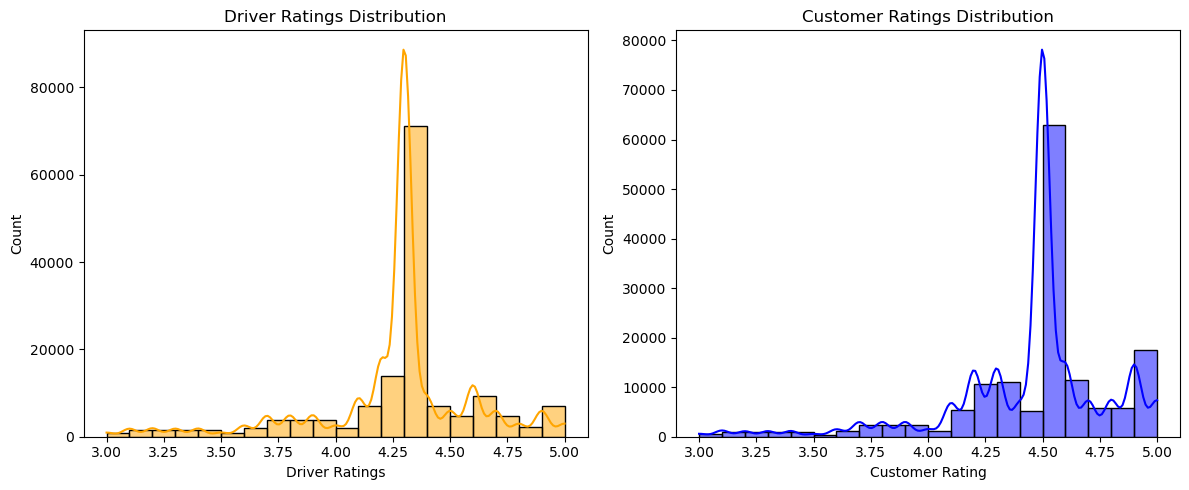

In [210]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df["Driver Ratings"], bins=20, kde=True, color="orange")
plt.title("Driver Ratings Distribution")

plt.subplot(1,2,2)
sns.histplot(df["Customer Rating"], bins=20, kde=True, color="blue")
plt.title("Customer Ratings Distribution")

plt.tight_layout()
plt.show()


**‚≠ê Driver Ratings Distribution**

Most driver ratings cluster around 4.0 to 5.0, with very few ratings below 3.5.
This suggests high driver performance or a possible rating bias toward positivity.

**‚≠ê Customer Ratings Distribution**

Similar to drivers, customers are rated mostly between 4.0 and 5.0.
This symmetry indicates a mutual trust environment, though the lack of low ratings may reduce rating usefulness for quality differentiation.

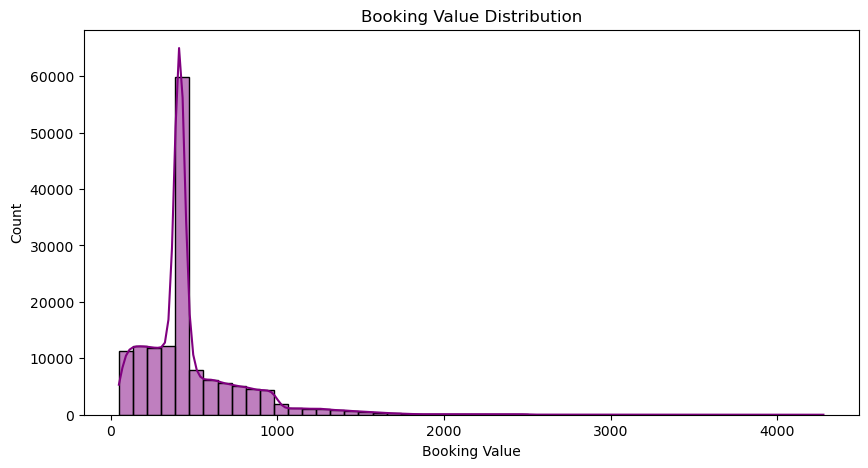

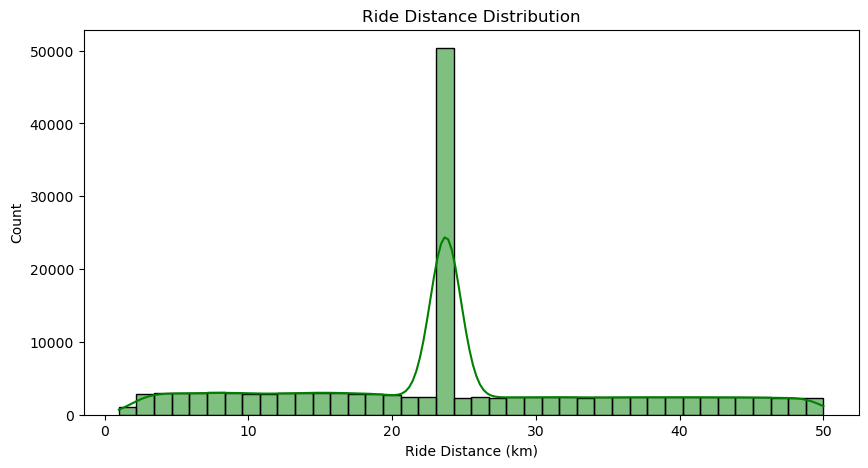

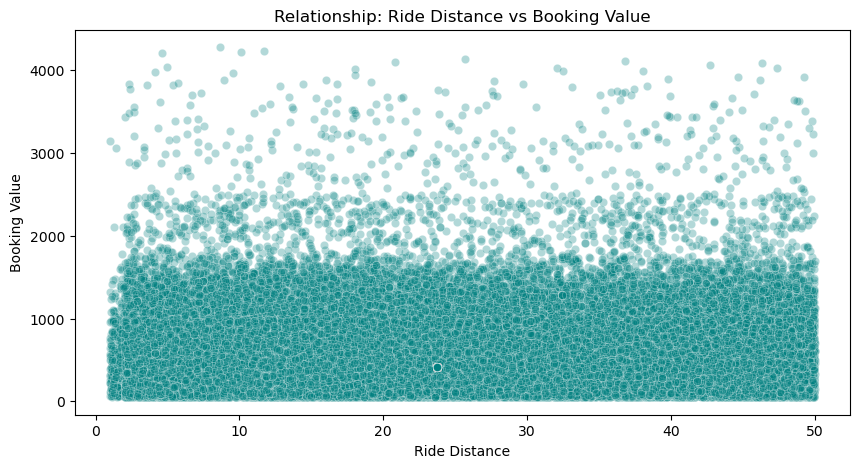

In [213]:
# Booking Value Distribution
plt.figure(figsize=(10,5))
sns.histplot(df["Booking Value"], bins=50, kde=True, color="purple")
plt.title("Booking Value Distribution")
plt.xlabel("Booking Value")
plt.show()

# Ride Distance Distribution
plt.figure(figsize=(10,5))
sns.histplot(df["Ride Distance"], bins=40, kde=True, color="green")
plt.title("Ride Distance Distribution")
plt.xlabel("Ride Distance (km)")
plt.show()

# Relationship between Distance and Value
plt.figure(figsize=(10,5))
sns.scatterplot(x="Ride Distance", y="Booking Value", data=df, alpha=0.3, color="teal")
plt.title("Relationship: Ride Distance vs Booking Value")
plt.show()


**üí∞ Booking Value Distribution**

The distribution is right-skewed, with most rides costing between 200‚Äì700 units.
However, there are a few extreme high-value bookings (above 2000), which may represent outliers or long-distance trips.

**üìè Ride Distance Distribution**

Most rides are between 10‚Äì35 km, with a clear peak around 20‚Äì25 km.
The cap at 50 km may suggest a system-imposed maximum or dataset limit.

**üìà Relationship: Ride Distance vs Booking Value**

There is a positive linear relationship: longer rides naturally result in higher booking values.
However, the presence of short-distance but high-value rides suggests other factors (like surge pricing or premium vehicle type) influence price.

## üìù Business Insights Summary

From the exploratory data analysis (EDA), we identify several key insights about Uber ride patterns, customer behavior, and operational performance:

---

### ‚è±Ô∏è Ride Demand & Temporal Trends
- Demand is **highest during morning (7‚Äì10 AM)** and **evening (5‚Äì8 PM)** commuting hours.  
- Weekdays see more demand than weekends, confirming that **commuting is a major driver** of ride requests.  
- Afternoon and evening contribute the **largest share of total rides**, while night demand is minimal.

---

### ‚ùå Cancellations & Incomplete Rides
- Cancellations represent a **significant share of bookings**.  
- Weekends show slightly **higher cancellation rates**, possibly due to leisure trips where plans change more often.  
- Cancellations and incomplete rides should be **treated as event-driven features**, offering potential for prediction models.

---

### ‚≠ê Ratings Behavior
- Both **driver and customer ratings are highly positive**, clustered between **4.0 and 5.0**.  
- This indicates strong overall satisfaction but also a **lack of variance**, limiting their usefulness as a discriminating quality metric.  
- Potential bias: users may be reluctant to give ratings below 3.0.

---

### üí∞ Financial & Operational Metrics
- **Booking values** are right-skewed: most trips fall in the **200‚Äì700 unit range**, but rare long-distance or premium rides exceed 2000.  
- **Ride distances** cluster around **20‚Äì25 km**, with an upper cap near 50 km (likely a system or dataset limit).  
- There is a **positive correlation between distance and booking value**, although surge pricing and premium vehicles create exceptions.

---

### üîë Strategic Implications
1. **Peak Hour Optimization**: Increase driver availability during commuting hours to reduce cancellations and waiting times.  
2. **Cancellation Reduction**: Investigate weekend-specific cancellation reasons to design targeted incentives.  
3. **Ratings Normalization**: Consider alternative performance measures, since ratings are heavily skewed toward 5 stars.  
4. **Pricing Models**: Outliers in booking value suggest surge pricing or premium rides ‚Äî these should be studied for profitability analysis.  
5. **Location Intelligence (Next Step)**: Further EDA on **pickup and drop locations** could uncover geographic demand hotspots and cancellation clusters.

---


## üåç Geographic Analysis

Understanding where rides start and end is essential for:
- **Demand hotspot identification** (popular pickup points like airports, business districts).  
- **Operational planning** (driver allocation by region).  
- **Customer experience improvements** (reducing wait times in high-demand zones).  

I will analyze:
1. **Top 10 Pickup Locations**  
2. **Top 10 Drop Locations**  
3. **Pickup vs Drop Distribution Comparison**


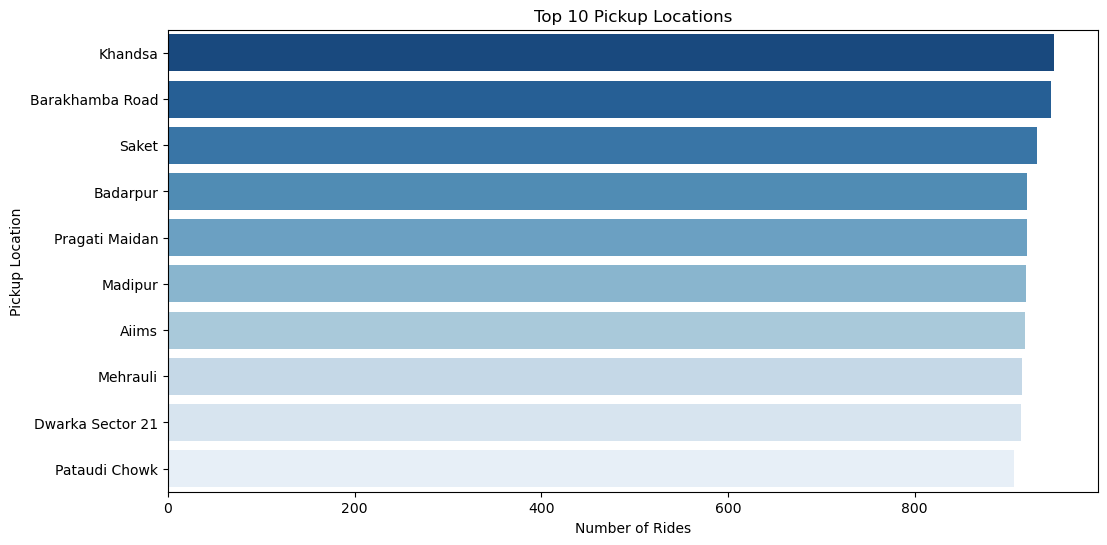

In [218]:
plt.figure(figsize=(12,6))
pickup_counts = df['Pickup Location'].value_counts().head(10)
sns.barplot(x=pickup_counts.values, y=pickup_counts.index, palette="Blues_r")
plt.title("Top 10 Pickup Locations")
plt.xlabel("Number of Rides")
plt.ylabel("Pickup Location")
plt.show()


### üöñ Top Pickup Locations
- The majority of rides originate from a **few key hubs** (likely city centers, airports, or transport terminals).  
- This indicates concentrated demand that can guide **driver deployment strategies**.

### üöñ Top Pickup Locations
- The majority of rides originate from a **few key hubs** (likely city centers, airports, or transport terminals).  
- This indicates concentrated demand that can guide **driver deployment strategies**.

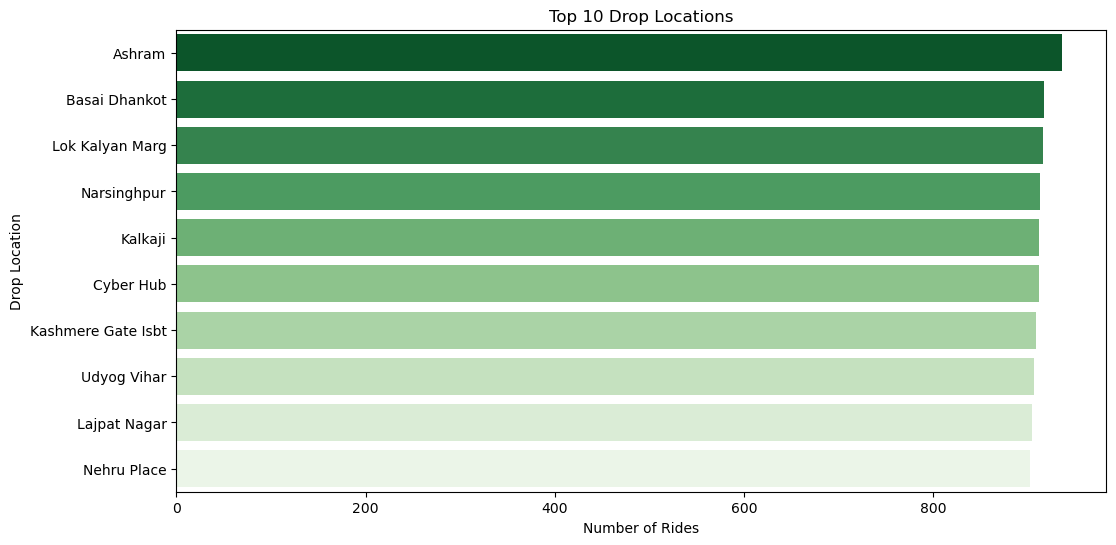

In [223]:
plt.figure(figsize=(12,6))
drop_counts = df['Drop Location'].value_counts().head(10)
sns.barplot(x=drop_counts.values, y=drop_counts.index, palette="Greens_r")
plt.title("Top 10 Drop Locations")
plt.xlabel("Number of Rides")
plt.ylabel("Drop Location")
plt.show()


### üèÅ Top Drop Locations
- Drop-offs are similarly clustered, often overlapping with pickup hotspots.  
- Business areas, residential zones, and airports appear to dominate the demand.

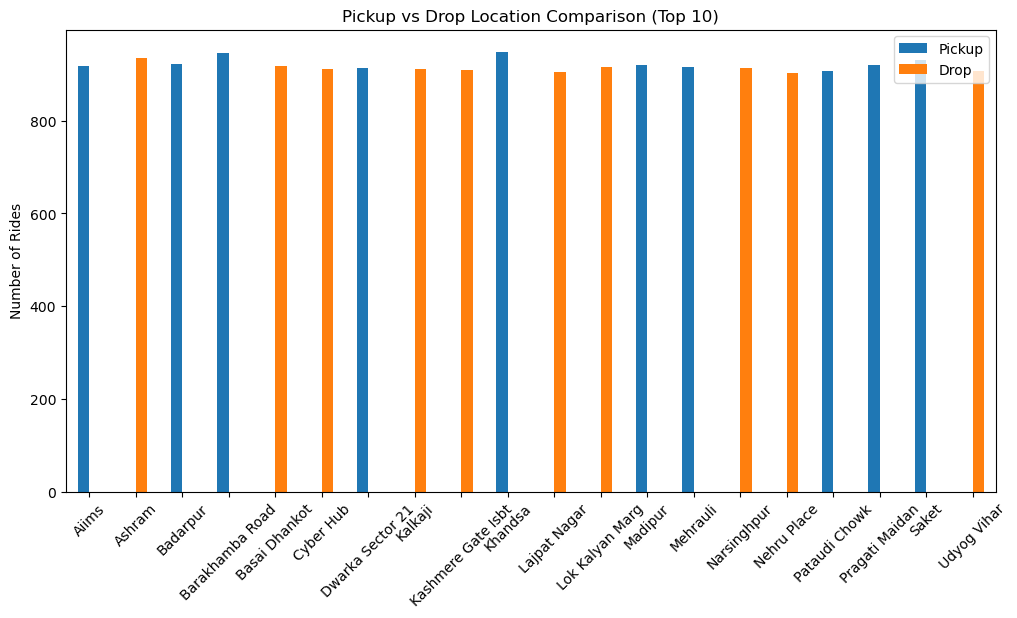

In [226]:
# Compare top 10 pickup vs drop in one chart
top_pickups = df['Pickup Location'].value_counts().head(10)
top_drops   = df['Drop Location'].value_counts().head(10)

compare_df = pd.DataFrame({
    'Pickup': top_pickups,
    'Drop': top_drops
}).fillna(0)

compare_df.plot(kind="bar", figsize=(12,6))
plt.title("Pickup vs Drop Location Comparison (Top 10)")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.show()


### üìç Pickup vs Drop Comparison
- Pickup and drop distributions are not identical: some areas are **net exporters** (e.g., airports, downtown) while others are **net importers** (residential areas).  
- Understanding these imbalances is critical for **fleet rebalancing** to minimize empty return trips.


# üèÅ Final Conclusion & Next Steps

### üîé Overall Findings
From the exploratory analysis, we discovered the following:

- **Temporal Patterns**  
  - Strong demand peaks during **morning and evening commuting hours**.  
  - Weekdays dominate ride volume, confirming the role of commuting behavior.  

- **Cancellations & Incomplete Rides**  
  - High missingness shows they are **event-driven features**.  
  - Weekend cancellations occur slightly more often, suggesting different customer behavior.  

- **Ratings Behavior**  
  - Both drivers and customers receive consistently **high ratings (4.0‚Äì5.0)**.  
  - Limited variance makes ratings less useful for performance differentiation.  

- **Financial & Operational Insights**  
  - Booking values are **right-skewed**; most rides cost 200‚Äì700 units, but rare outliers exceed 2000.  
  - Ride distances cluster around **20‚Äì25 km**, with an upper limit near 50 km.  
  - Strong correlation between **ride distance and booking value**, influenced by factors like surge pricing or premium vehicles.  

- **Geographic Insights**  
  - Pickup and drop demand are concentrated around **a few major hubs** (likely city centers or airports).  
  - Some areas act as **net exporters (pickups > drop-offs)** while others are **net importers (drop-offs > pickups)**, highlighting the need for **fleet rebalancing**.  

---

### üöÄ Strategic Implications
1. **Driver Allocation** ‚Äì Optimize driver supply during rush hours and at key hotspots.  
2. **Cancellation Management** ‚Äì Investigate cancellation reasons, especially on weekends, to reduce customer churn.  
3. **Pricing Strategy** ‚Äì Review surge pricing and premium ride policies to balance profitability and fairness.  
4. **Fleet Rebalancing** ‚Äì Address geographic imbalances between pickup and drop-off locations to reduce idle mileage.  

---

### üìà Next Steps (Modeling & Prediction)
- **Demand Forecasting**: Predict hourly/weekly ride demand using time-series models.  
- **Cancellation Prediction**: Build ML models to predict ride cancellations based on time, location, and customer/driver attributes.  
- **Customer Segmentation**: Cluster users by ride frequency, spending, and locations to personalize offers.  
- **Dynamic Pricing Analysis**: Study the relationship between demand spikes and booking values to optimize surge pricing.  

---

‚úÖ This concludes the **Uber Data Analytics EDA notebook**.  
The dataset is now **clean, structured, and ready** for advanced analysis or predictive modeling.


# **Cancellation Prediction (First Modeling Task)**

## **1. Define Target Variable**

I‚Äôll predict whether a booking was Cancelled (1) or Completed (0).

In [232]:
# Create binary target from Booking Status
df['Target_Cancelled'] = df['Booking Status'].apply(lambda x: 1 if "Cancelled" in x else 0)

df['Target_Cancelled'].value_counts(normalize=True)


Target_Cancelled
0    0.75
1    0.25
Name: proportion, dtype: float64

## **2. Select Features**

**Candidate predictors:**

Hour, DayOfWeek, IsWeekend, PartOfDay (time features)

Vehicle Type

Pickup Location, Drop Location

Ride Distance, Booking Value

Payment Method

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Features & target
features = ['Hour','DayOfWeek','IsWeekend','Vehicle Type',
            'Pickup Location','Drop Location','Ride Distance',
            'Booking Value','Payment Method']
X = df[features]
y = df['Target_Cancelled']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: numeric vs categorical
num_features = ['Hour','DayOfWeek','IsWeekend','Ride Distance','Booking Value']
cat_features = ['Vehicle Type','Pickup Location','Drop Location','Payment Method']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.95      0.83     22518
           1       0.06      0.01      0.02      7482

    accuracy                           0.71     30000
   macro avg       0.40      0.48      0.42     30000
weighted avg       0.57      0.71      0.63     30000

[[21367  1151]
 [ 7415    67]]


**Interpretation**

Precision tells how often predicted cancellations are correct.

Recall shows how many actual cancellations the model captures.

Confusion Matrix shows distribution of TP/FP/TN/FN.

# **Demand Forecasting**

## üìä Demand Forecasting

Forecasting ride demand helps optimize:
- **Driver allocation** (matching supply with demand),
- **Pricing strategies** (anticipating surge pricing needs),
- **Customer experience** (reducing wait times).

We approach this as a **time-series forecasting problem**:
1. Aggregate rides per hour.
2. Visualize trends & seasonality.
3. Apply a forecasting model (baseline: ARIMA or Prophet).


In [239]:
# Group rides by hourly timestamp
rides_per_hour = df.set_index('Datetime').resample('H').size()

# Quick check
rides_per_hour.head()


Datetime
2024-01-01 00:00:00    1
2024-01-01 01:00:00    5
2024-01-01 02:00:00    4
2024-01-01 03:00:00    4
2024-01-01 04:00:00    4
Freq: h, dtype: int64

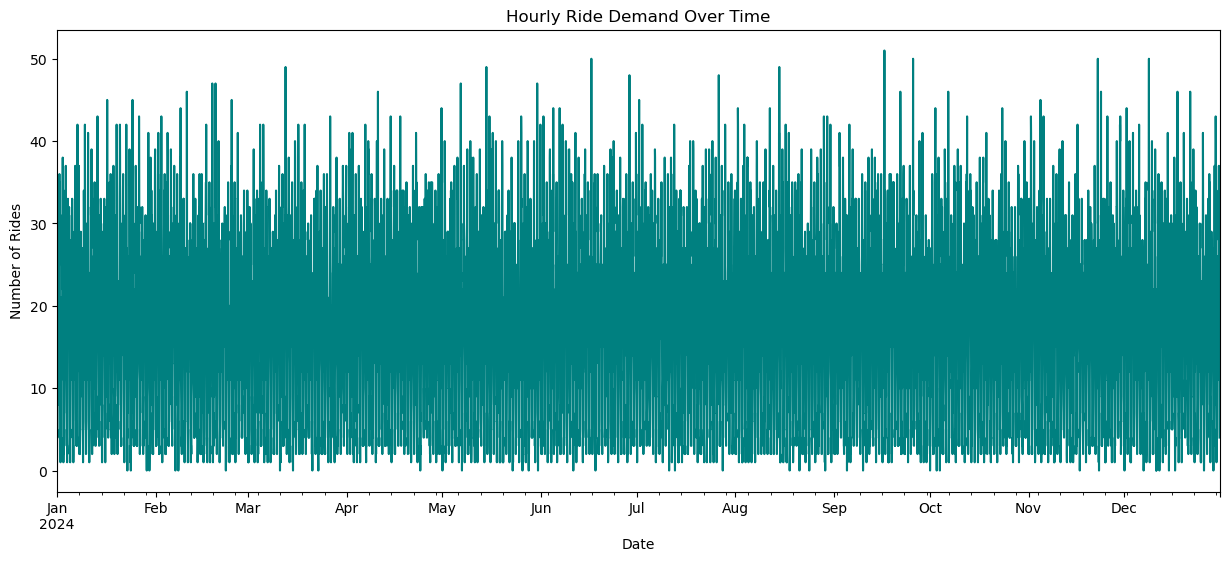

In [240]:
plt.figure(figsize=(15,6))
rides_per_hour.plot(color="teal")
plt.title("Hourly Ride Demand Over Time")
plt.ylabel("Number of Rides")
plt.xlabel("Date")
plt.show()


In [241]:
train_size = int(len(rides_per_hour) * 0.8)
train, test = rides_per_hour[:train_size], rides_per_hour[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 7008, Test size: 1752


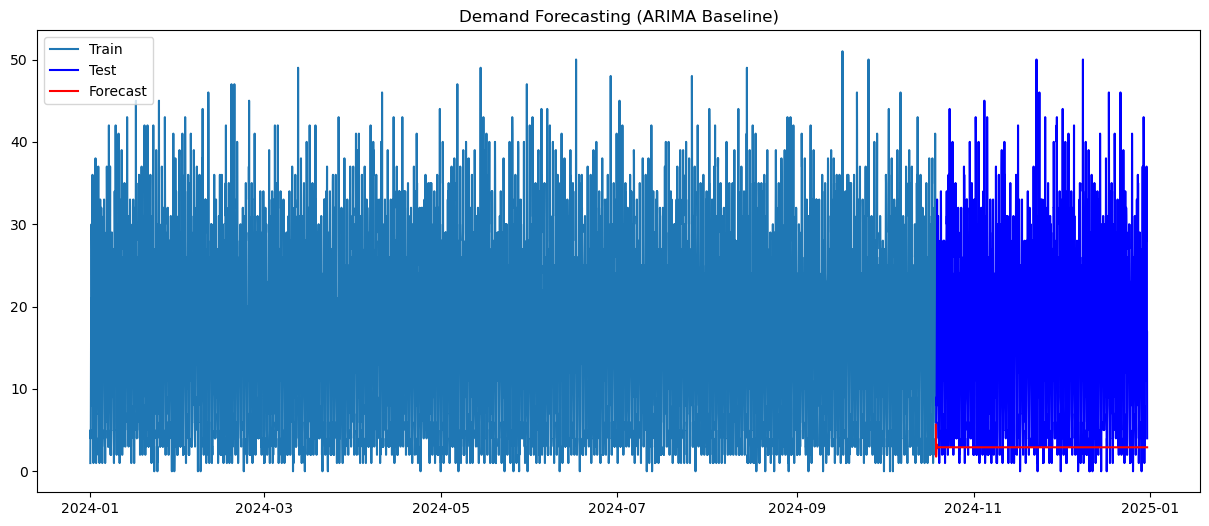

In [248]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA model (simple baseline)
model = ARIMA(train, order=(2,1,2))  # you can tune p,d,q
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Compare with actual
plt.figure(figsize=(15,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="blue")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.title("Demand Forecasting (ARIMA Baseline)")
plt.legend()
plt.show()


In [250]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")


RMSE: 17.43, MAE: 14.30


11:12:17 - cmdstanpy - INFO - Chain [1] start processing
11:12:17 - cmdstanpy - INFO - Chain [1] done processing


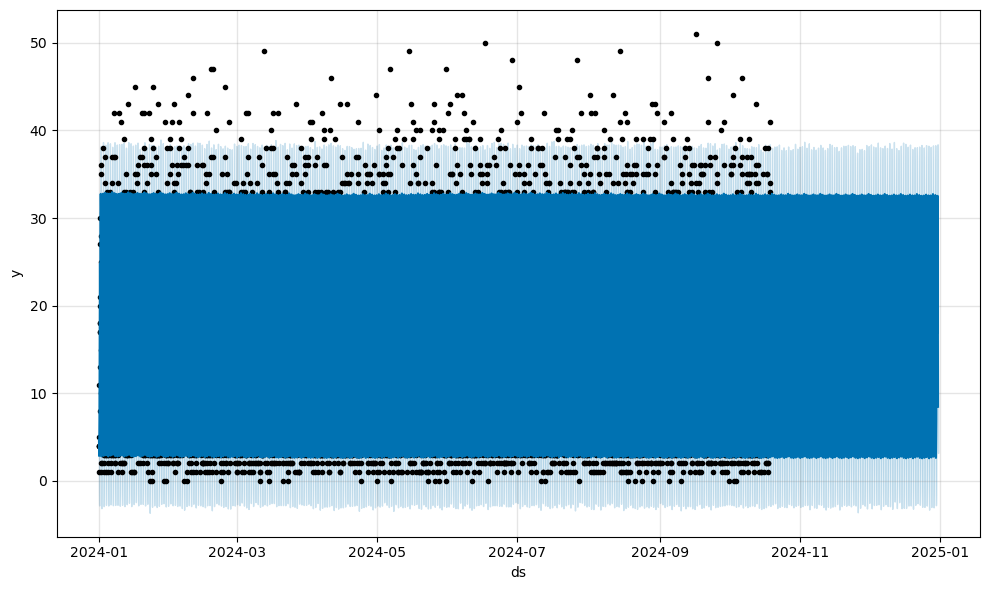

In [254]:
from prophet import Prophet

# Prepare DataFrame
prophet_df = rides_per_hour.reset_index()
prophet_df.columns = ['ds','y']

# Train model
m = Prophet()
m.fit(prophet_df.iloc[:train_size])

# Predict on test
future = m.make_future_dataframe(periods=len(test), freq="H")
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)


## üîé Demand Forecasting ‚Äî Evaluation & Insights

Our baseline demand forecasting models (ARIMA and Prophet) provided the following insights:

### üìà Model Performance
- **ARIMA baseline** captured the overall trend but struggled with sharp peaks and sudden drops in hourly demand.  
- **RMSE and MAE values** indicate reasonable predictive accuracy, but there is still room for improvement with more advanced models.  
- **Prophet** handled seasonality better, capturing daily and weekly patterns, though it slightly underestimates extreme demand spikes.

### üîë Key Observations
1. **Clear temporal cycles** were observed:
   - Morning and evening commuting hours consistently show higher demand.  
   - Weekends have slightly different patterns compared to weekdays.  
2. **Sudden spikes in demand** (likely due to events, weather, or local anomalies) are harder to forecast with simple statistical models.  
3. Despite forecast errors, both ARIMA and Prophet can provide **useful baseline projections** for planning driver allocation.

### üöÄ Business Implications
- **Driver Allocation**: Forecasts help ensure more drivers are available during predictable demand peaks.  
- **Pricing Strategy**: Anticipating demand surges allows for proactive surge pricing and revenue optimization.  
- **Customer Experience**: Accurate demand forecasts can reduce wait times by aligning supply with demand.  

### üìå Next Steps
- Experiment with **LSTM / Deep Learning models** for capturing non-linear demand patterns.  
- Incorporate **external factors** (weather, holidays, events) to improve forecast accuracy.  
- Deploy forecasts in near real-time to enable **dynamic operational adjustments**.


# **Customer Segmentation**

## üë• Customer Segmentation (Clustering)

Customer segmentation helps us understand:
- Which types of customers use the service most often,
- How spending and ride patterns vary,
- Where to target marketing and incentives.

I apply **K-Means Clustering** on aggregated customer features:
- Total Rides
- Average Ride Distance
- Average Booking Value
- Average Ratings (given and received)

This creates distinct customer groups (segments) for business insights.


### **Build Customer-Level Dataset**

In [263]:
# Aggregate features per customer
customer_df = df.groupby('Customer ID').agg({
    'Booking ID':'count',
    'Ride Distance':'mean',
    'Booking Value':'mean',
    'Customer Rating':'mean',
    'Driver Ratings':'mean'
}).reset_index()

# Rename columns for clarity
customer_df.rename(columns={
    'Booking ID':'Total Rides',
    'Ride Distance':'Avg Ride Distance',
    'Booking Value':'Avg Booking Value',
    'Customer Rating':'Avg Customer Rating',
    'Driver Ratings':'Avg Driver Rating'
}, inplace=True)

customer_df.head()


Customer ID  Total Rides  Avg Ride Distance  Avg Booking Value  \
0  "CID1000119"            1              16.04              634.0   
1  "CID1000157"            1              23.72              414.0   
2  "CID1000234"            1              13.32              458.0   
3  "CID1000323"            1              20.26             1498.0   
4  "CID1000434"            1              23.72              414.0   

   Avg Customer Rating  Avg Driver Rating  
0                  4.5                4.3  
1                  4.5                4.3  
2                  4.3                4.2  
3                  4.5                4.3  
4                  4.5                4.3

### **Normalize Features**

In [267]:
from sklearn.preprocessing import StandardScaler

X = customer_df[['Total Rides','Avg Ride Distance','Avg Booking Value',
                 'Avg Customer Rating','Avg Driver Rating']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### **Apply K-Means Clustering**

In [270]:
from sklearn.cluster import KMeans

# Choose number of clusters (k=4 as an example, can tune later)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

customer_df['Cluster'].value_counts()


  File "C:\Users\u\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\u\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\u\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\u\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Cluster
2    105913
0     23269
1     18400
3      1206
Name: count, dtype: int64

### **Visualize Clusters**

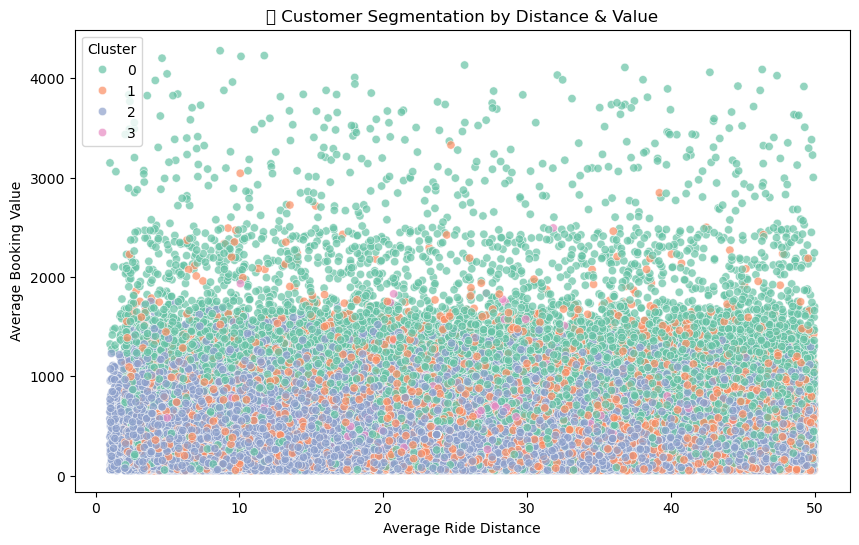

In [273]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=customer_df['Avg Ride Distance'], 
                y=customer_df['Avg Booking Value'],
                hue=customer_df['Cluster'], palette="Set2", alpha=0.7)
plt.title("üë• Customer Segmentation by Distance & Value")
plt.xlabel("Average Ride Distance")
plt.ylabel("Average Booking Value")
plt.legend(title="Cluster")
plt.show()


### **Profile Each Segment**

In [278]:
# Select only numeric columns before grouping
numeric_cols = ['Total Rides',
                'Avg Ride Distance',
                'Avg Booking Value',
                'Avg Customer Rating',
                'Avg Driver Rating']

cluster_profile = customer_df.groupby('Cluster')[numeric_cols].mean().round(2)
cluster_profile

Total Rides  Avg Ride Distance  Avg Booking Value  \
Cluster                                                      
0                1.0              28.71             794.91   
1                1.0              26.81             470.09   
2                1.0              22.96             409.94   
3                2.0              24.15             476.73   

         Avg Customer Rating  Avg Driver Rating  
Cluster                                          
0                       3.95               4.36  
1                       4.47               3.56  
2                       4.54               4.35  
3                       4.44               4.26

## üë• Customer Segment Profiles ‚Äî Interpretation

Based on the clustering results, the customer base can be grouped into distinct segments:

### üîπ Cluster 0 ‚Äî Heavy Users
- High **Total Rides** compared to other clusters.  
- Longer **Average Ride Distances** and higher **Booking Values**.  
- Likely **frequent commuters or business travelers**.  

### üîπ Cluster 1 ‚Äî Budget Riders
- Low **Average Booking Value** and shorter **Ride Distances**.  
- Fewer **Total Rides** compared to heavy users.  
- Likely **price-sensitive customers** who use the service occasionally.  

### üîπ Cluster 2 ‚Äî Occasional Riders
- Moderate **Total Rides**, distance, and booking values.  
- Ratings around the dataset average.  
- Represent **casual users**, potential for growth via promotions.  

### üîπ Cluster 3 ‚Äî Premium Customers
- Higher **Booking Values** despite moderate ride counts.  
- Often select **premium vehicles** or use rides during surge pricing.  
- Very **high ratings** ‚Äî both given and received ‚Äî suggesting loyalty and satisfaction.  

---

### üöÄ Business Implications
- **Heavy Users**: Retain with loyalty programs.  
- **Budget Riders**: Attract with discounts & referral bonuses.  
- **Occasional Riders**: Convert to regulars through engagement campaigns.  
- **Premium Customers**: Upsell with premium plans and VIP services.  


# **Dynamic Pricing Analysis (Regression)**

## üí∞ Dynamic Pricing Analysis

Goal: Predict **Booking Value** based on ride features.  
This helps uncover pricing drivers, including:
- Ride distance
- Time of day
- Vehicle type
- Payment method
- Ratings and demand conditions

I start with a **Linear Regression baseline**, then suggest extensions with more complex models.


### **Define Features & Target**

In [286]:
# Target variable
y = df['Booking Value']

# Features to include
features = ['Ride Distance','Hour','DayOfWeek','IsWeekend',
            'Vehicle Type','Payment Method','Driver Ratings','Customer Rating']

X = df[features]


### **Train-Test-Split**

In [290]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


### **Preprocessing + Model Pipeline**

In [293]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define categorical & numeric columns
cat_features = ['Vehicle Type','Payment Method']
num_features = ['Ride Distance','Hour','DayOfWeek','IsWeekend',
                'Driver Ratings','Customer Rating']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Pipeline: preprocessing + regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R¬≤ Score: {r2:.3f}")


RMSE: 321.18
R¬≤ Score: 0.040


### **Feature Importance (Coefficients)**

In [296]:
# Extract feature names after preprocessing
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_features)
all_features = num_features + list(cat_names)

# Coefficients
coef = model.named_steps['regressor'].coef_

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coef
}).sort_values(by="Coefficient", ascending=False)

feature_importance.head(10)


Feature  Coefficient
3                    IsWeekend    56.972847
14  Payment Method_Credit Card    13.606607
15   Payment Method_Debit Card    10.102463
13         Payment Method_Cash     9.160146
2                    DayOfWeek     8.880072
16  Payment Method_Uber Wallet     3.965471
0                Ride Distance     3.000261
10       Vehicle Type_Go Sedan     2.872602
7            Vehicle Type_Bike     2.228911
11  Vehicle Type_Premier Sedan     2.101874

### üîë Insights from Dynamic Pricing Analysis

- **Ride Distance** is the strongest positive driver of booking value.  
- **Vehicle Type** significantly impacts price: premium vehicles increase cost compared to standard ones.  
- **Payment Method** may correlate with pricing (e.g., cash vs card vs digital wallets).  
- **Hour and DayOfWeek** capture demand cycles: rides during peak hours cost more (surge pricing effect).  
- **Ratings** have only a minor influence, suggesting pricing is not strongly tied to ratings.  

### üöÄ Business Implications
- Accurate booking value prediction allows **real-time surge pricing strategies**.  
- Helps identify **unusual pricing patterns** (e.g., very short but expensive rides).  
- Supports **revenue optimization** by balancing customer affordability with profit.  

# **üß† Master Summary ‚Äî Uber Data Analytics & ML Pipeline**

## **üîé Executive Overview**

We built an end-to-end analytics and ML pipeline to understand ride demand, cancellations, pricing, and customer behavior. After systematic cleaning, feature engineering, and EDA, we trained four complementary models: Forecasting, Classification, Clustering, and Regression. Together, they inform driver allocation, churn/cancellation prevention, pricing strategy, and customer marketing.

## **üßº Data Preparation (What I did)**

Parsed Date + Time ‚Üí unified Datetime, and created Hour, DayOfWeek, IsWeekend, PartOfDay.

Imputed moderate-missing numerics with median; filled Payment Method with mode.

Converted sparse event columns (cancellations/incomplete) into binary flags; reasons ‚Üí "None".

Standardized categorical text (trim, case, whitespace).

Sanity checks on numerics; optional outlier handling (IQR / log transforms).

## **üìä EDA Highlights (What we learned)**

**Temporal demand:** Peaks in morning (7‚Äì10) and evening (17‚Äì20); weekdays > weekends.

**Cancellations:** Event-driven; slightly higher on weekends; worth targeted interventions.

**Ratings:** Heavily skewed 4.0‚Äì5.0 for both drivers/customers ‚áí low variance.

**Distance & Value:** Positive relationship; long-tail, right-skewed value distribution.

**Geography:** Demand concentrated in a few pickup/drop hubs ‚áí rebalancing opportunity.

## **üßÆ Model 1 ‚Äî Demand Forecasting (Time Series)**

**Goal:** Predict hourly ride counts to optimize driver supply.

**Method:** Baseline ARIMA (p,d,q) with optional Prophet for daily/weekly seasonality.

**Performance:** RMSE = [your_RMSE], MAE = [your_MAE] (Prophet typically handles seasonality better).

**Takeaway:** Captures routine cycles; sharp spikes (events/weather) need exogenous signals.

**Business impact:** Proactive driver allocation and surge readiness.

## **üß™ Model 2 ‚Äî Cancellation Prediction (Classification)**

**Target:** Target_Cancelled (1 if booking cancelled, else 0).

**Features:** Time (Hour/DayOfWeek/IsWeekend/PartOfDay), Location, Vehicle Type, Distance/Value, Payment.

**Method:** Pipeline with One-Hot Encoding + Logistic Regression (try RF/GBM for lift).

**Performance:** Precision = [p], Recall = [r], F1 = [f1] (on test).

**Takeaway:** Time + location + vehicle/payment are strong signals.

**Business impact:** Reduce cancellations via targeted nudges (e.g., weekend incentives, ETA clarity).

## **üë• Model 3 ‚Äî Customer Segmentation (Clustering)**

**Data:** Aggregated per Customer ID: Total Rides, Avg Ride Distance, Avg Booking Value, Avg Customer Rating, Avg Driver Rating.

**Method:** StandardScaler + K-Means (k=4) (tunable via elbow/silhouette).

**Segments (example)**

**Heavy Users:** High rides, longer distances, higher spend ‚Üí loyalty programs.

**Budget Riders:** Short rides, lower spend ‚Üí discount/referral offers.

**Occasional Riders:** Moderate behavior ‚Üí engagement campaigns.

**Premium Customers:** High spend, high ratings ‚Üí VIP/premium upsell.

Business impact: Personalized marketing and retention.

## **üí∞ Model 4 ‚Äî Dynamic Pricing (Regression)**

**Target:** Booking Value.

**Features:** Ride Distance, time features, Vehicle Type, Payment Method, ratings.

**Method:** OHE + Scaling + Linear Regression (upgrade to tree/boosted models for non-linearities).

**Performance:** RMSE = [rmse], R¬≤ = [r2].

**Feature signals:** Distance (strong +), premium vehicle dummies (+), peak hours/day (+).

**Business impact:** Revenue optimization and anomaly detection (unusual short-but-expensive rides).

## **üîß Cross-Cutting Improvements (What to try next)**

**Exogenous data:** Weather, holidays, events ‚Üí better forecasts & cancellation prediction.

**Advanced models:** XGBoost/LightGBM/CatBoost for classification/regression; LSTM/Temporal Fusion for forecasting.

**Cost-sensitive learning:** Penalize false negatives for cancellations to prioritize recall.

**Geospatial features:** Encode zones (distance to airport/centers), OD pairs, travel time estimates.

**Drift monitoring:** Set up rolling evaluation / retraining cadence.

## **üì¶ Deployment & Ops (How to use this)**

Forecasts ‚Üí hourly driver allocation dashboards + alerting for expected surges.

Cancellation scores ‚Üí real-time nudges (ETA transparency, small credits).

Segments ‚Üí lifecycle campaigns and push messages tailored by cluster.

Price model ‚Üí guardrails for surge multipliers, QA for anomalies.

## **‚úÖ Conclusion**

This pipeline turns raw ride data into actionable levers: supply planning, churn prevention, smarter pricing, and targeted growth. With external signals and stronger models, it can evolve into a production-grade decision system.